# Reference
- Erik Linder-Norén, "PyTorch-GAN", GitHub repository, https://github.com/eriklindernoren/PyTorch-GAN


# LSGAN

## Import libraries

In [1]:
import argparse
import os
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


## Option

In [2]:
class Option():
    n_epochs = 200 # number of epochs of training
    batch_size = 64 # size of the batches
    lr = 0.0002 # adam: learning rate
    b1 = 0.5 # adam: decay of first order momentum of gradient
    b2 = 0.999 # adam: decay of first order momentum of gradient
    n_cpu = 8 # number of cpu threads to use during batch generation
    latent_dim = 100 # dimensionality of the latent space
    img_size = 32 # size of each image dimension
    channels = 1 # number of image channels
    sample_interval = 500 # interval between image sampling

opt = Option()
cuda = True if torch.cuda.is_available() else False

## Models

In [3]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Linear(128 * ds_size ** 2, 1)

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

## Loss & Optimizer

In [4]:
# !!! Minimizes MSE instead of BCE
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


100.0%


Extracting ../../data/mnist\MNIST\raw\train-images-idx3-ubyte.gz to ../../data/mnist\MNIST\raw



100.0%


Extracting ../../data/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ../../data/mnist\MNIST\raw



100.0%


Extracting ../../data/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ../../data/mnist\MNIST\raw



100.0%

Extracting ../../data/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../../data/mnist\MNIST\raw



## Training

[Epoch 0/200] [Batch 0/938] [D loss: 0.513500] [G loss: 1.026841]


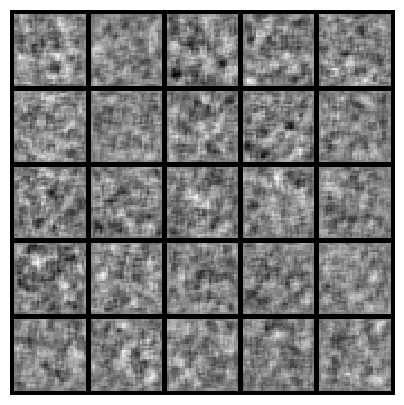

[Epoch 0/200] [Batch 500/938] [D loss: 0.249433] [G loss: 0.244265]


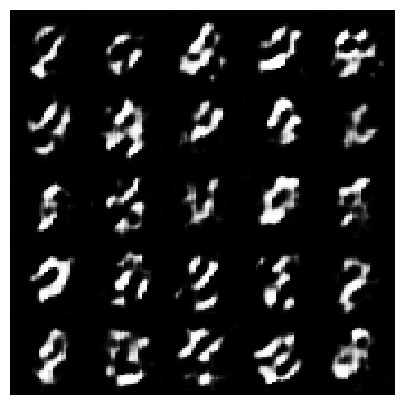

[Epoch 1/200] [Batch 62/938] [D loss: 0.238921] [G loss: 0.252138]


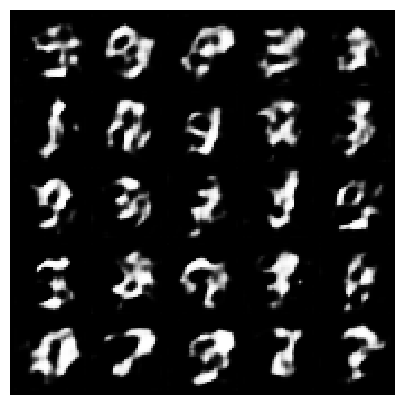

[Epoch 1/200] [Batch 562/938] [D loss: 0.253665] [G loss: 0.259285]


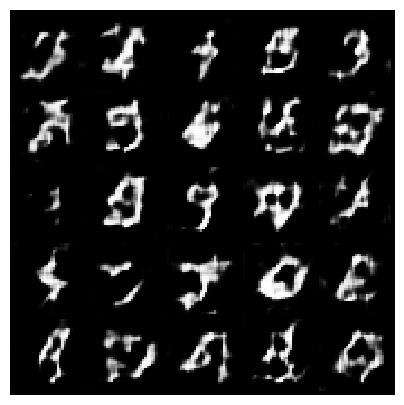

[Epoch 2/200] [Batch 124/938] [D loss: 0.240985] [G loss: 0.323949]


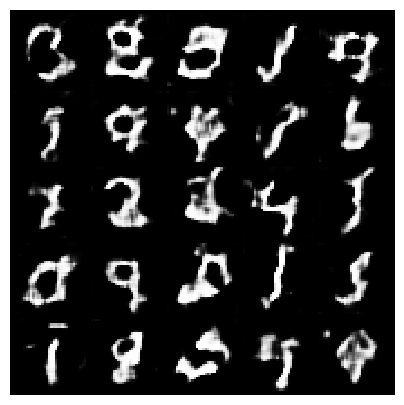

[Epoch 2/200] [Batch 624/938] [D loss: 0.256945] [G loss: 0.203590]


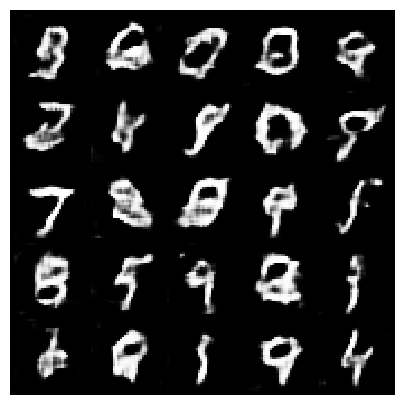

[Epoch 3/200] [Batch 186/938] [D loss: 0.212834] [G loss: 0.370913]


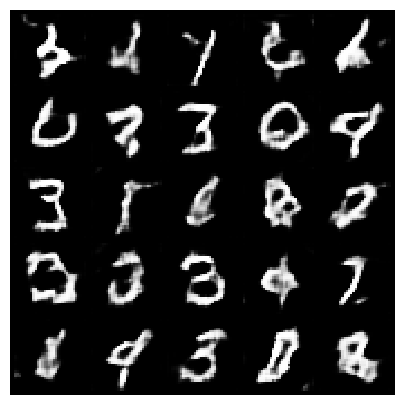

[Epoch 3/200] [Batch 686/938] [D loss: 0.232351] [G loss: 0.171071]


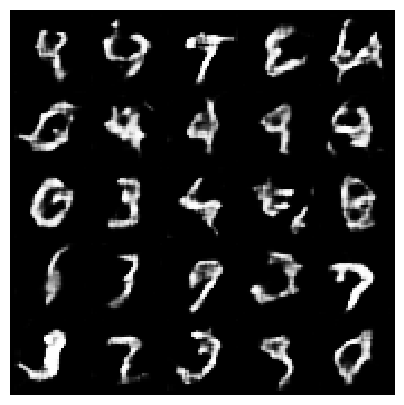

[Epoch 4/200] [Batch 248/938] [D loss: 0.229018] [G loss: 0.471082]


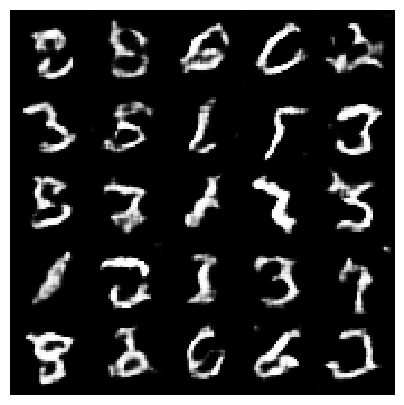

[Epoch 4/200] [Batch 748/938] [D loss: 0.279205] [G loss: 0.506303]


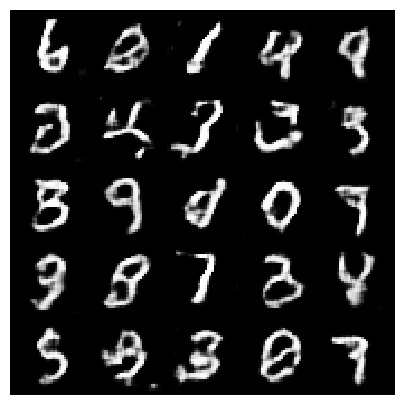

[Epoch 5/200] [Batch 310/938] [D loss: 0.193253] [G loss: 0.439472]


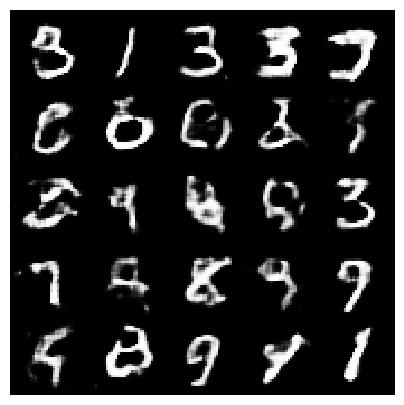

[Epoch 5/200] [Batch 810/938] [D loss: 0.253042] [G loss: 0.271689]


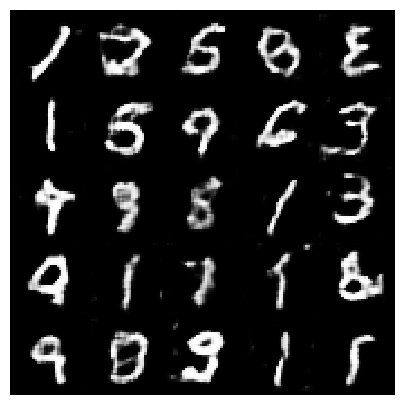

[Epoch 6/200] [Batch 372/938] [D loss: 0.184035] [G loss: 0.217683]


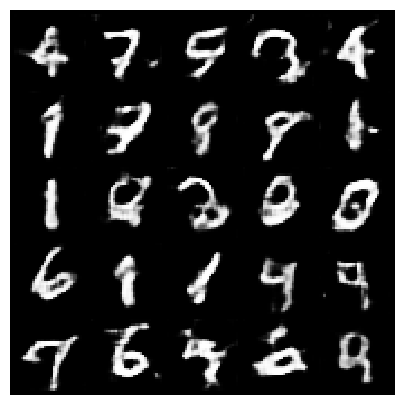

[Epoch 6/200] [Batch 872/938] [D loss: 0.241206] [G loss: 0.326787]


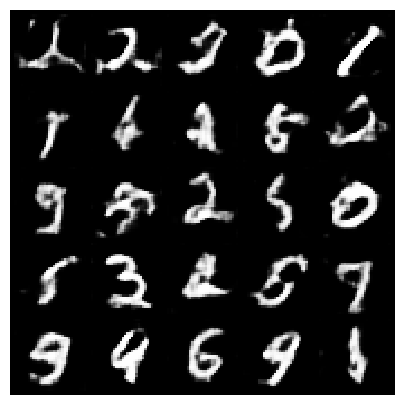

[Epoch 7/200] [Batch 434/938] [D loss: 0.196737] [G loss: 0.328773]


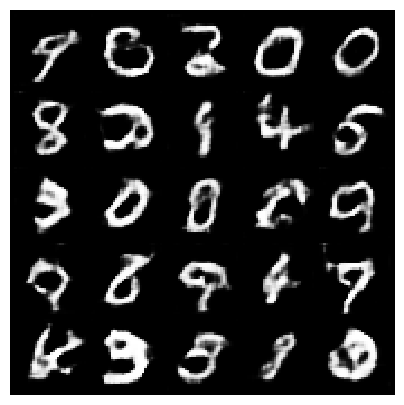

[Epoch 7/200] [Batch 934/938] [D loss: 0.156508] [G loss: 0.405978]


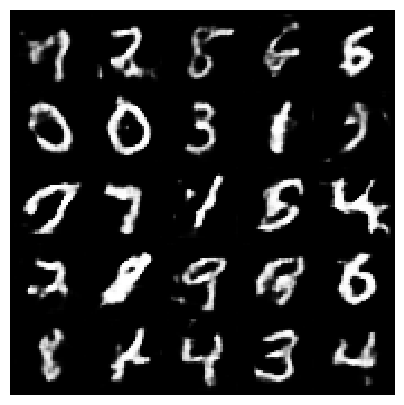

[Epoch 8/200] [Batch 496/938] [D loss: 0.318467] [G loss: 0.297187]


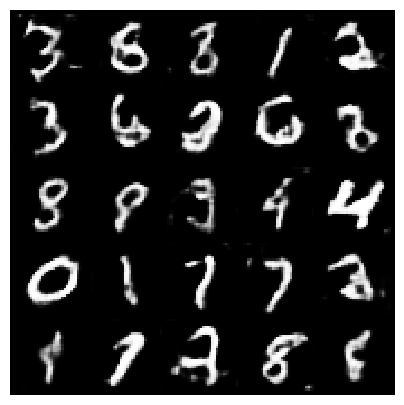

[Epoch 9/200] [Batch 58/938] [D loss: 0.244075] [G loss: 0.247820]


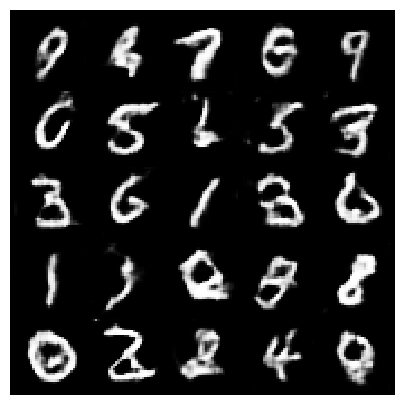

[Epoch 9/200] [Batch 558/938] [D loss: 0.191522] [G loss: 0.533186]


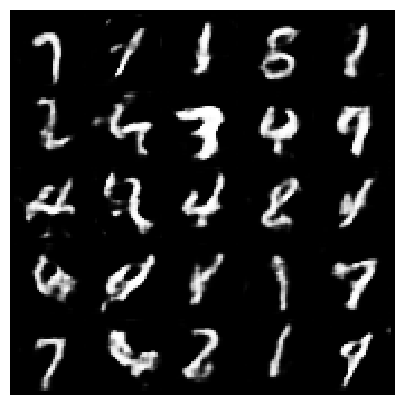

[Epoch 10/200] [Batch 120/938] [D loss: 0.222133] [G loss: 0.576800]


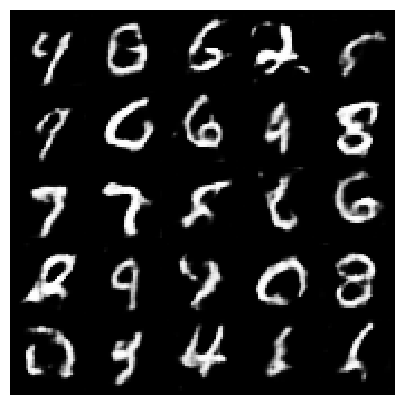

[Epoch 10/200] [Batch 620/938] [D loss: 0.188922] [G loss: 0.237656]


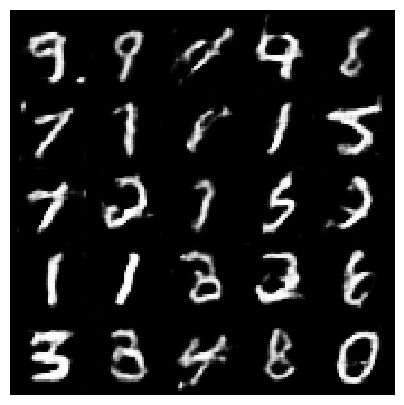

[Epoch 11/200] [Batch 182/938] [D loss: 0.152277] [G loss: 0.415225]


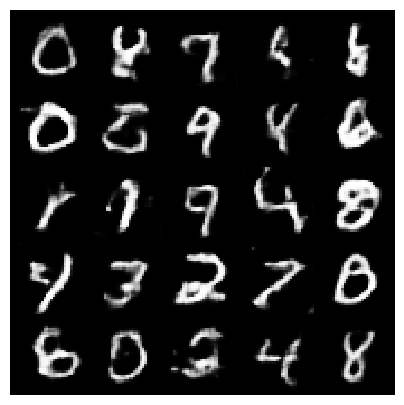

[Epoch 11/200] [Batch 682/938] [D loss: 0.123381] [G loss: 0.226078]


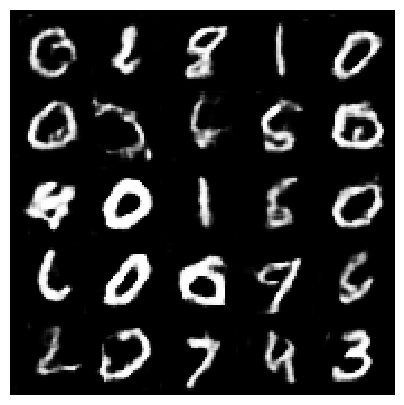

[Epoch 12/200] [Batch 244/938] [D loss: 0.205559] [G loss: 0.374334]


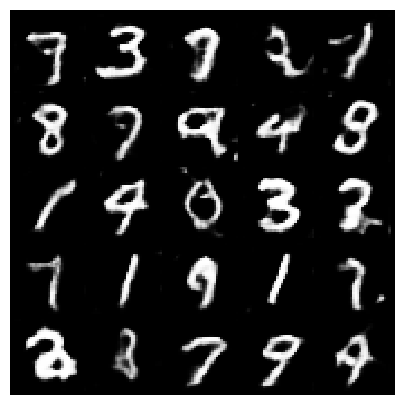

[Epoch 12/200] [Batch 744/938] [D loss: 0.224804] [G loss: 0.315944]


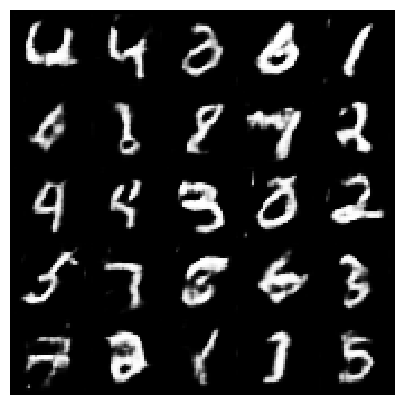

[Epoch 13/200] [Batch 306/938] [D loss: 0.137093] [G loss: 0.387271]


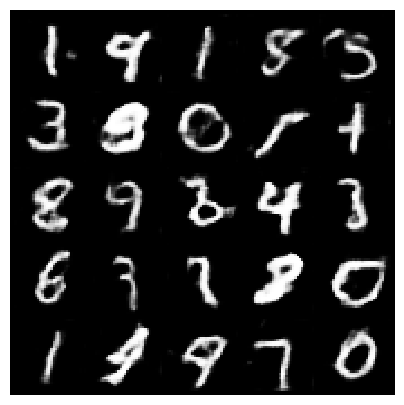

[Epoch 13/200] [Batch 806/938] [D loss: 0.155832] [G loss: 0.275007]


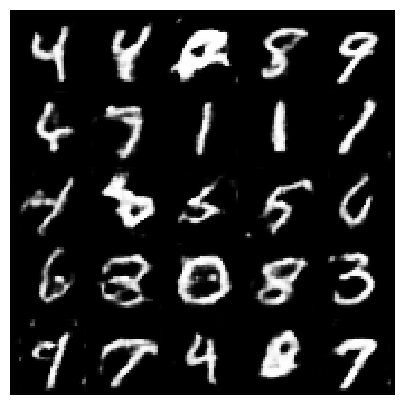

[Epoch 14/200] [Batch 368/938] [D loss: 0.116630] [G loss: 0.164282]


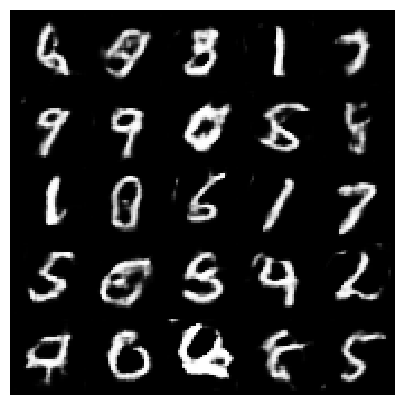

[Epoch 14/200] [Batch 868/938] [D loss: 0.184097] [G loss: 0.294418]


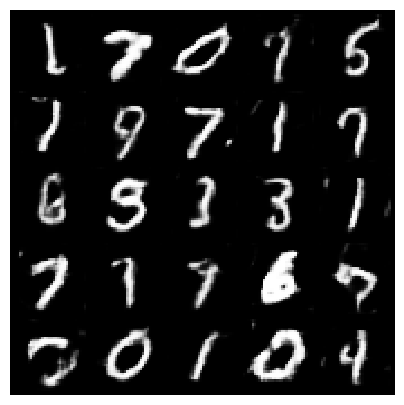

[Epoch 15/200] [Batch 430/938] [D loss: 0.150793] [G loss: 0.278242]


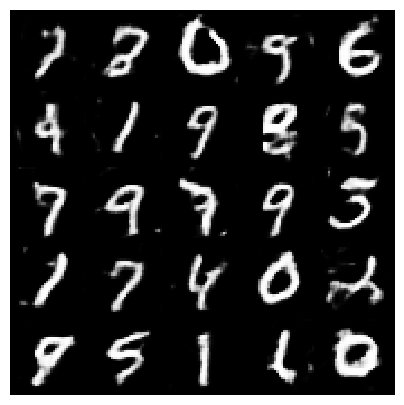

[Epoch 15/200] [Batch 930/938] [D loss: 0.334473] [G loss: 0.449481]


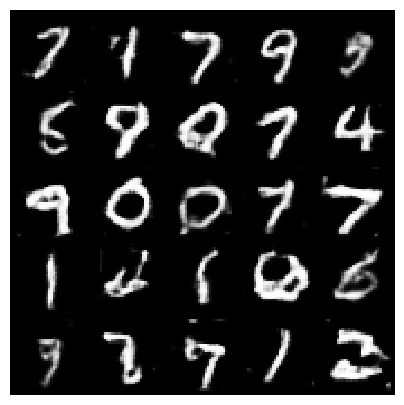

[Epoch 16/200] [Batch 492/938] [D loss: 0.188041] [G loss: 0.228292]


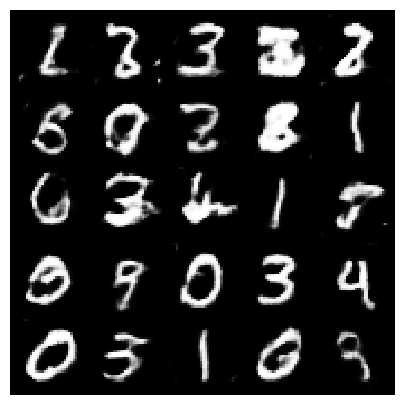

[Epoch 17/200] [Batch 54/938] [D loss: 0.242007] [G loss: 0.216399]


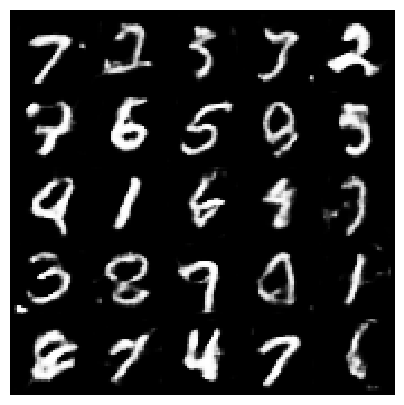

[Epoch 17/200] [Batch 554/938] [D loss: 0.178885] [G loss: 0.273643]


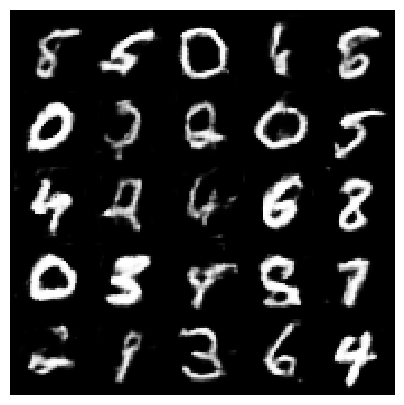

[Epoch 18/200] [Batch 116/938] [D loss: 0.129042] [G loss: 0.343822]


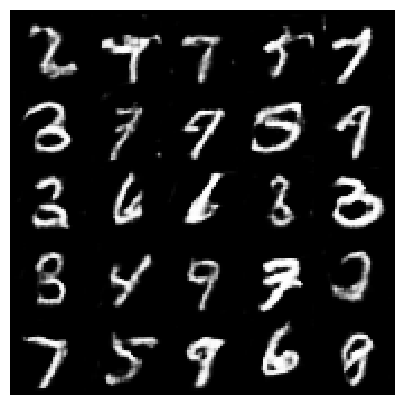

[Epoch 18/200] [Batch 616/938] [D loss: 0.155563] [G loss: 0.115048]


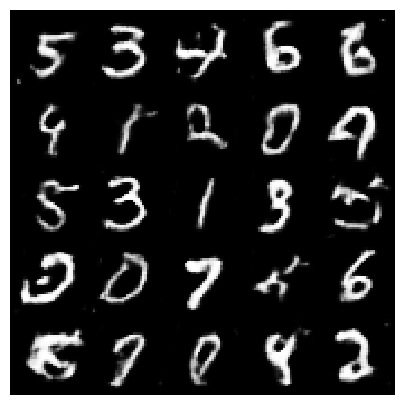

[Epoch 19/200] [Batch 178/938] [D loss: 0.119472] [G loss: 0.411347]


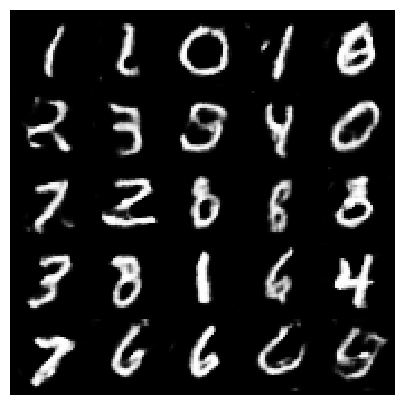

[Epoch 19/200] [Batch 678/938] [D loss: 0.136632] [G loss: 0.318365]


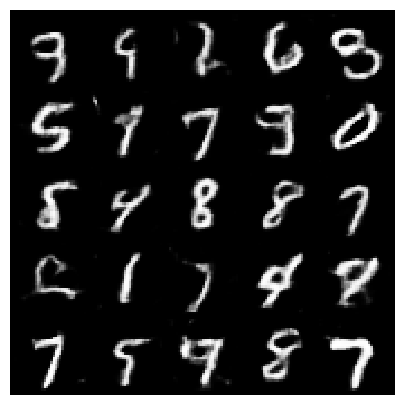

[Epoch 20/200] [Batch 240/938] [D loss: 0.163873] [G loss: 0.262078]


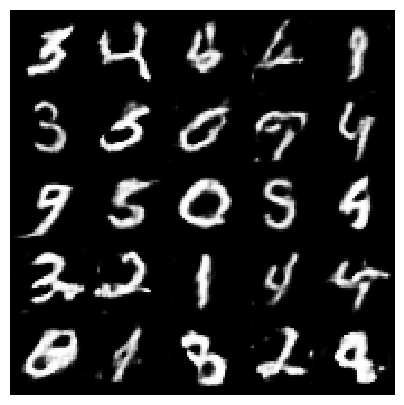

[Epoch 20/200] [Batch 740/938] [D loss: 0.151032] [G loss: 0.201482]


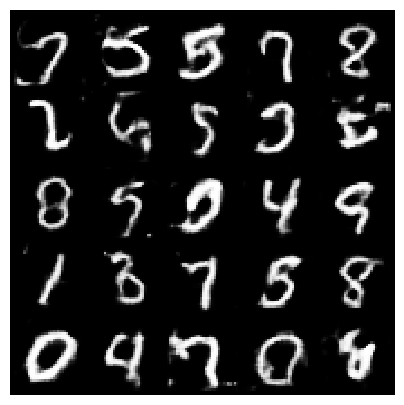

[Epoch 21/200] [Batch 302/938] [D loss: 0.147681] [G loss: 0.876292]


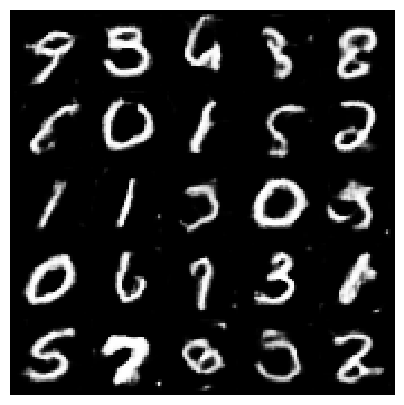

[Epoch 21/200] [Batch 802/938] [D loss: 0.285958] [G loss: 0.568292]


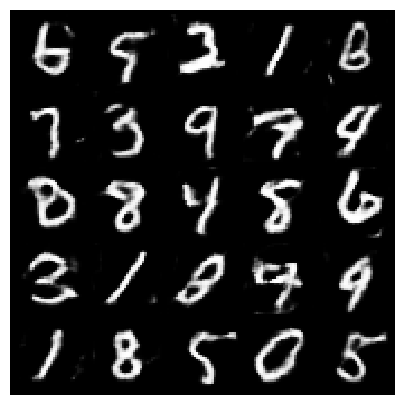

[Epoch 22/200] [Batch 364/938] [D loss: 0.155196] [G loss: 0.329157]


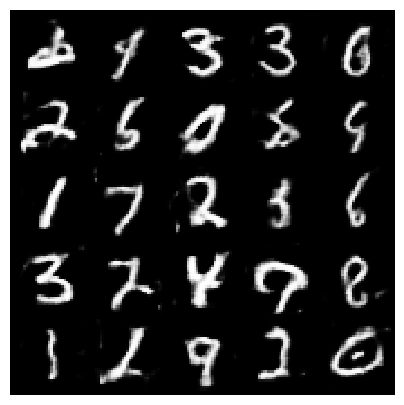

[Epoch 22/200] [Batch 864/938] [D loss: 0.221726] [G loss: 0.414429]


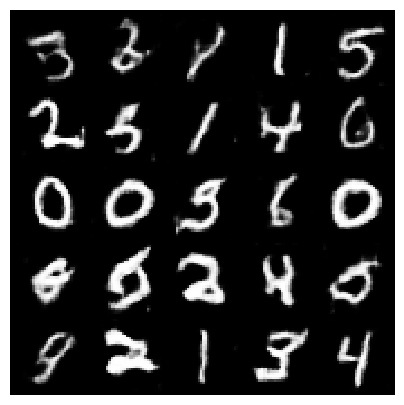

[Epoch 23/200] [Batch 426/938] [D loss: 0.140746] [G loss: 0.266868]


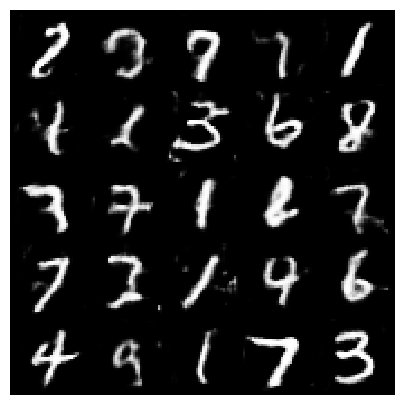

[Epoch 23/200] [Batch 926/938] [D loss: 0.165092] [G loss: 0.169152]


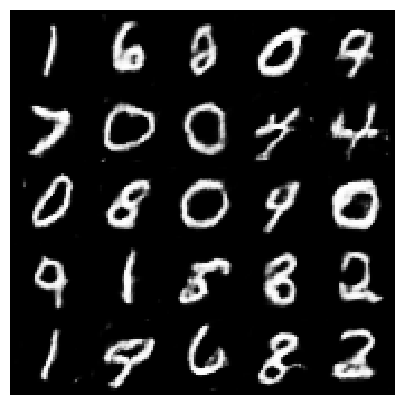

[Epoch 24/200] [Batch 488/938] [D loss: 0.264173] [G loss: 0.611240]


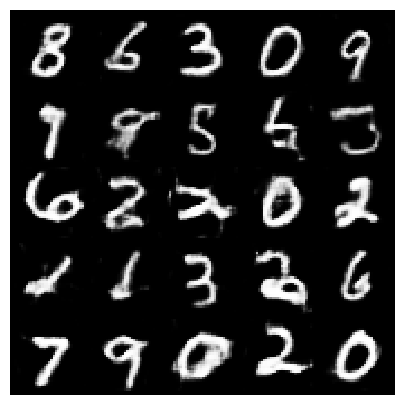

[Epoch 25/200] [Batch 50/938] [D loss: 0.139354] [G loss: 0.796020]


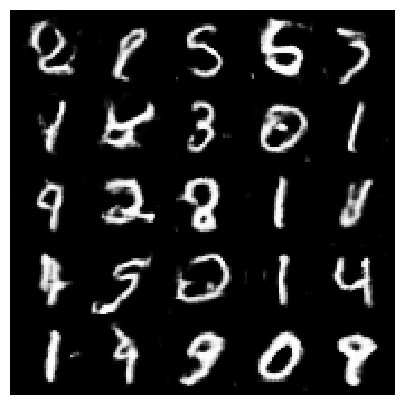

[Epoch 25/200] [Batch 550/938] [D loss: 0.140355] [G loss: 0.658128]


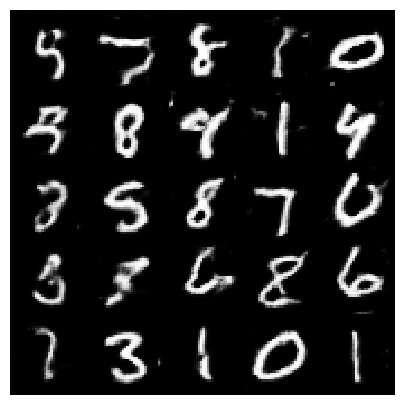

[Epoch 26/200] [Batch 112/938] [D loss: 0.219601] [G loss: 0.697056]


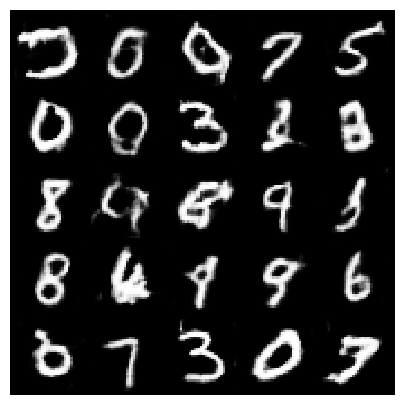

[Epoch 26/200] [Batch 612/938] [D loss: 0.197116] [G loss: 0.302409]


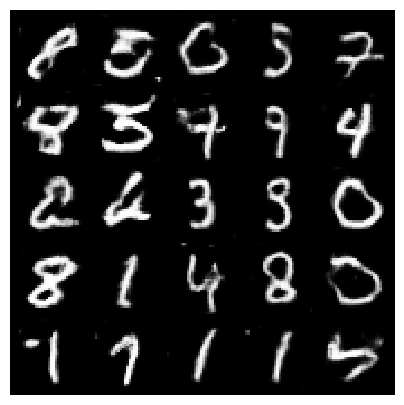

[Epoch 27/200] [Batch 174/938] [D loss: 0.205213] [G loss: 0.227358]


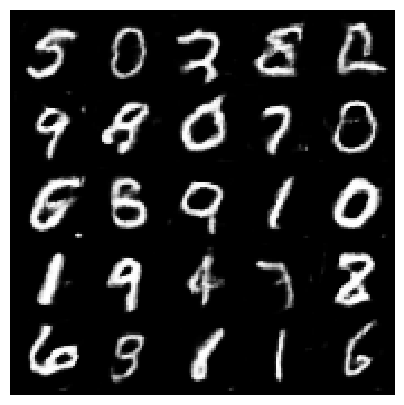

[Epoch 27/200] [Batch 674/938] [D loss: 0.113799] [G loss: 0.515757]


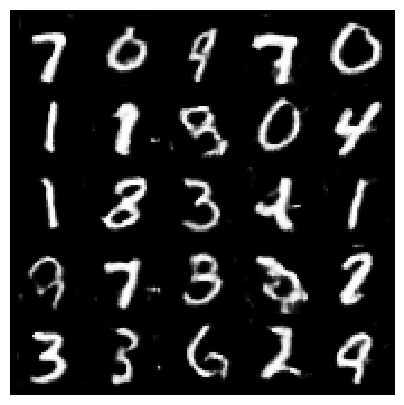

[Epoch 28/200] [Batch 236/938] [D loss: 0.165563] [G loss: 0.428840]


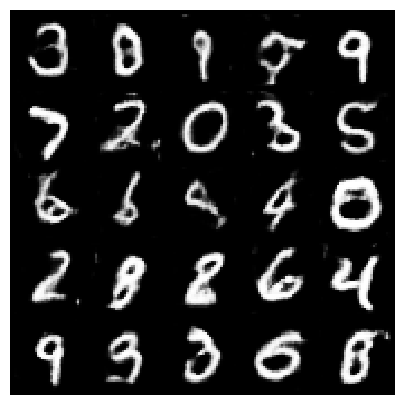

[Epoch 28/200] [Batch 736/938] [D loss: 0.083730] [G loss: 0.564610]


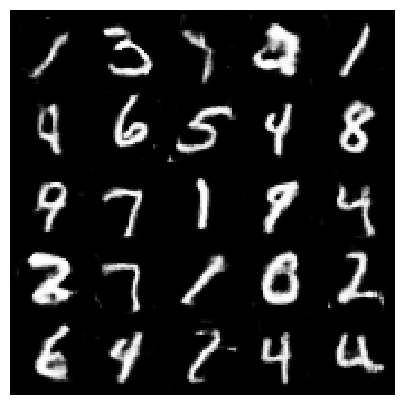

[Epoch 29/200] [Batch 298/938] [D loss: 0.175144] [G loss: 0.875855]


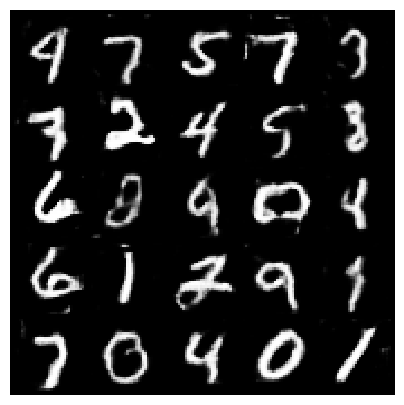

[Epoch 29/200] [Batch 798/938] [D loss: 0.228153] [G loss: 0.463709]


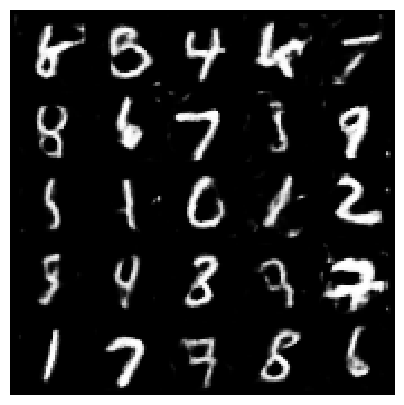

[Epoch 30/200] [Batch 360/938] [D loss: 0.153217] [G loss: 0.629854]


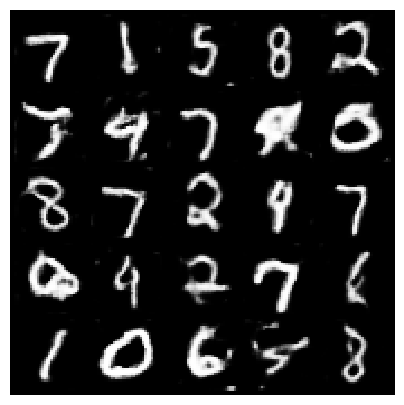

[Epoch 30/200] [Batch 860/938] [D loss: 0.153874] [G loss: 0.296517]


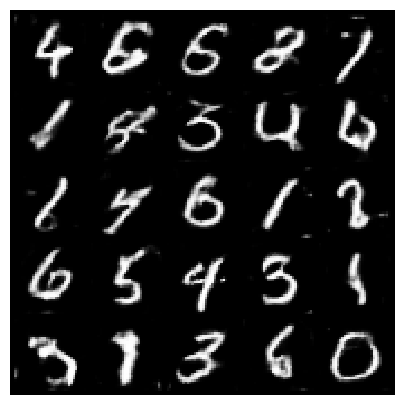

[Epoch 31/200] [Batch 422/938] [D loss: 0.280553] [G loss: 0.328879]


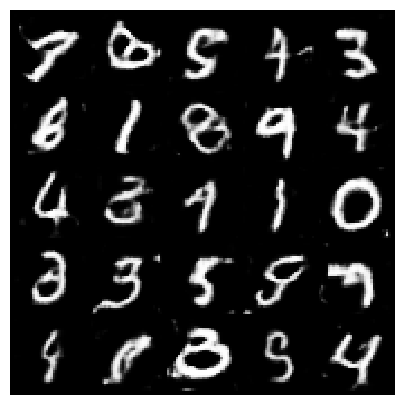

[Epoch 31/200] [Batch 922/938] [D loss: 0.114221] [G loss: 0.411517]


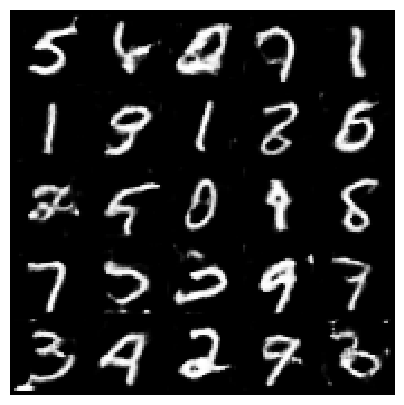

[Epoch 32/200] [Batch 484/938] [D loss: 0.147960] [G loss: 0.472923]


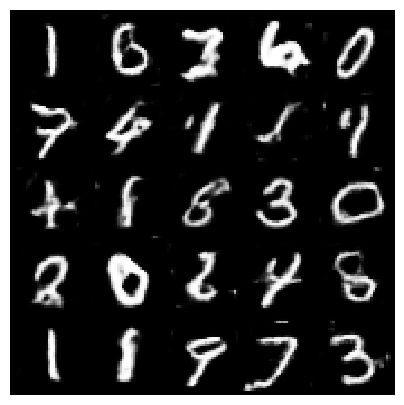

[Epoch 33/200] [Batch 46/938] [D loss: 0.261953] [G loss: 0.510825]


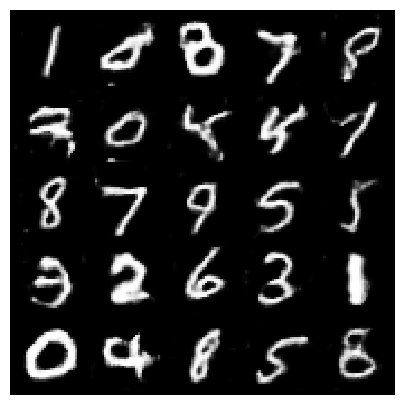

[Epoch 33/200] [Batch 546/938] [D loss: 0.143614] [G loss: 0.206555]


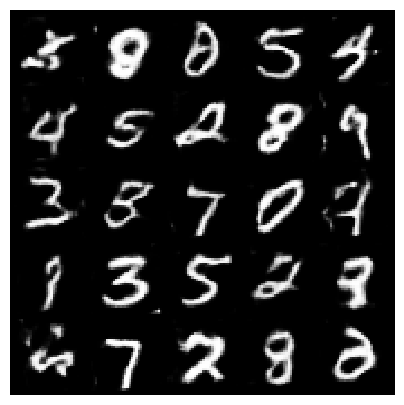

[Epoch 34/200] [Batch 108/938] [D loss: 0.070105] [G loss: 0.196037]


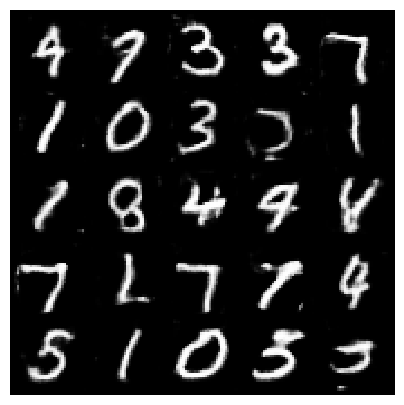

[Epoch 34/200] [Batch 608/938] [D loss: 0.192418] [G loss: 0.207451]


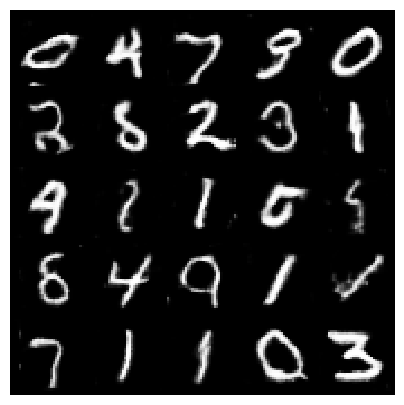

[Epoch 35/200] [Batch 170/938] [D loss: 0.238084] [G loss: 0.363207]


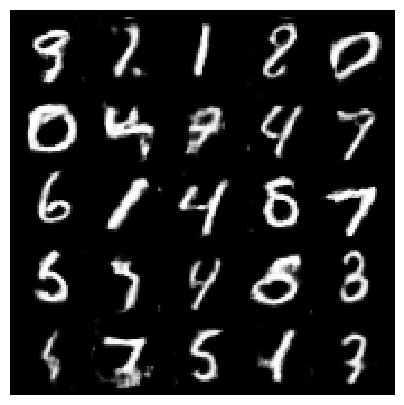

[Epoch 35/200] [Batch 670/938] [D loss: 0.176926] [G loss: 0.482439]


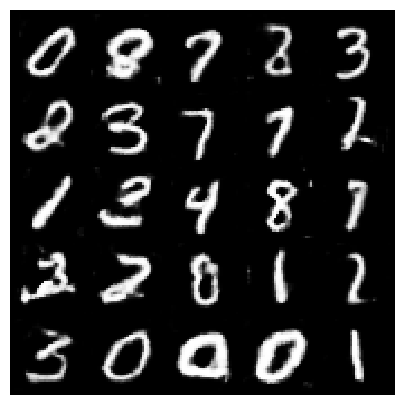

[Epoch 36/200] [Batch 232/938] [D loss: 0.155178] [G loss: 0.497139]


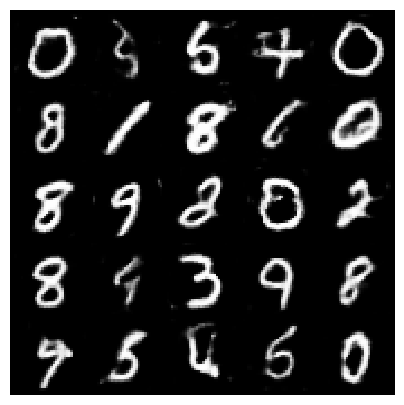

KeyboardInterrupt: 

In [5]:



# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()


        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

            plt.figure(figsize = (5,5))
            img1 = cv2.imread("images/%d.png" %batches_done)
            plt.imshow(img1, interpolation='nearest')
            plt.axis('off')
            plt.show()